I’ve always been really interested in biostatistics and how data science gets used in real medical settings, so I wanted to do something that reflects that. A lot of my classes in health informatics and computer simulations have involved building small models like this, so running a simulation felt natural.

I simulated patient arrivals using a Poisson process and modeled triage with a min-heap (for severe cases) and a FIFO queue (for mild cases). Doctors always prioritize severe patients (lowest severity numbers) then treat mild patients in arrival order. I varied the number of doctors (1, 3, 6) and measured average waiting times by severity, percent delayed beyond clinical thresholds and doctor utilization.

In [43]:
# ER triage simulation
import random as ran
import math
import queue as q
import heapq as heap
import statistics as stats
import matplotlib.pyplot as plt

In [44]:
# time config
TIME_UNIT = 1 # 1 min per step in sim 

In [45]:
# Agents

class Patient:
    def __init__(self, pid, arrival_time, severity):
        self.pid = pid
        self.arrival_time = arrival_time
        self.severity = severity # 1 (most severe) ... 5 (least)
        self.service_start = None
        self.service_end = None
        # service duration
        # more severe = longer duration
        if self.severity <= 2:
            self.service_duration = ran.randint(12,25) # in minutes
        elif self.severity == 3:
            self.service_duration = ran.randint(8,16)
        else:
            self.service_duration = ran.randint(4,10)

    def wait_time(self):
        if self.service_start is None:
            return None
        return self.service_start - self.arrival_time

In [46]:
# generate arrival times
# poisson distribution for arrival times
def generate_arrivals(sim_time_minutes, arrival_rate_per_min):
    arrivals = []
    t = 0.0
    pid = 0
    while t < sim_time_minutes:
        inter = ran.expovariate(arrival_rate_per_min)
        t += inter
        if t >= sim_time_minutes:
            break # stops if exceeds sim time
        
        # severity probabilities: 1:5%, 2:10%, 3:25%, 4:30%, 5:30%
        severity = ran.choices([1,2,3,4,5], 
                               weights=[0.05, 0.10, 0.25, 0.30, 0.30])[0]

        arrivals.append(Patient(pid, int(math.floor(t)), severity))
        pid += 1

    return arrivals

In [47]:
# simulation 
def run_sim(num_doctors=3, 
            sim_time_minutes=8*60, # 8 hours
            arrival_rate_per_min=0.15,
            delay_thresholds = {1:30, 2:30, 3:60, 4:90, 5:120}):
    
    """ 
    Simulate ER triage with given parameters. 
    Returns a dict with patient and queue statistics.
    """

    arrivals = generate_arrivals(sim_time_minutes, arrival_rate_per_min)
    # sort by arrival time
    arrivals.sort(key=lambda p: p.arrival_time)
    arrival_idx = 0

    severe_heap = [] # min-heap for severe patients (severity 1-3)
    mild_queue = q.Queue() # FIFO queue for mild patients (severity 4-5)

    # doctors: list of dicts {busy_until:int, patient:Patient or None}
    doctors = [{'busy_until': -1, 'patient':None, 'worked':0} for i in range(num_doctors)]

    all_patients = [] # to store all patients 

    queue_lengths = [] # total waiting (heap + queue) per min
    severe_lengths = [] # severe waiting (heap) per min
    mild_lengths = [] # mild waiting (queue) per min
    time_points = list(range(sim_time_minutes))

    for t in time_points:
        # 1. add new arrivals at this min
        while arrival_idx < len(arrivals) and arrivals[arrival_idx].arrival_time <= t:
            p = arrivals[arrival_idx]
            all_patients.append(p)
            if p.severity <= 2:
                # use pid attribute from Patient
                heap_item = (p.severity, p.arrival_time, p.pid, p)  # (severity, arrival_time, pid, patient)
                heap.heappush(severe_heap, heap_item)
            else:
                mild_queue.put(p)
            arrival_idx += 1
    
        # 2. free doctors who've finished
        for doc in doctors:
            if doc['patient'] is not None and doc['busy_until'] <= t:
                # doctor finished with current patient
                doc['patient'] = None
        
        # 3. assign doctors to waiting patients (priority to severe)
        for doc in doctors:
            if doc['patient'] is None:
                assigned = None
                if severe_heap:
                    # pop most severe patient
                    _, _, _, patient = heap.heappop(severe_heap)
                    assigned = patient
                elif not mild_queue.empty():
                    assigned = mild_queue.get()
                if assigned:
                    assigned.service_start = t
                    assigned.service_end = t + assigned.service_duration
                    doc['patient'] = assigned
                    doc['busy_until'] = assigned.service_end
                    doc['worked'] += assigned.service_duration
        
        # 4. record queue lengths
        queue_lengths.append(len(severe_heap) + mild_queue.qsize())
        severe_lengths.append(len(severe_heap))
        mild_lengths.append(mild_queue.qsize())

    # after sim time finishes doctors can finish patients in progress (they already have service_end set)
    finished = [p for p in all_patients if p.service_end is not None]
    unfinshed = [p for p in all_patients if p.service_start is None] # never got treated

    # calculate stats
    waits_by_sev = {1: [], 2: [], 3: [], 4: [], 5: []}
    for p in finished:
        waits_by_sev[p.severity].append(p.wait_time())

    avg_waits = {sev: (stats.mean(waits_by_sev[sev]) if waits_by_sev[sev] else 0) for sev in waits_by_sev}

    # percent delayed beyond thresholds
    percent_delayed = {}
    for sev, thresh in delay_thresholds.items():
        L = waits_by_sev[sev]
        if not L:
            percent_delayed[sev] = 0.0
        else:
            percent_delayed[sev] = 100.0 * sum(1 for w in L if w > thresh) / len(L)
    
    total_treated = len(finished)
    total_arrived = len(all_patients)
    doc_utilization = [d['worked'] / sim_time_minutes for d in doctors]

    metrics = {
        'num_doctors': num_doctors,
        'sim_time_min': sim_time_minutes,
        'total_arrived': total_arrived,
        'total_treated': total_treated,
        'avg_waits': avg_waits,
        'percent_delayed': percent_delayed,
        'doc_utilization_percent': doc_utilization,
        'unfinished_patients': len(unfinshed)
    }

    timeseries = {
        'time': time_points,
        'total_queue': queue_lengths,
        'severe_queue': severe_lengths,
        'mild_queue': mild_lengths
    }

    metrics["raw_waits"] = waits_by_sev

    return metrics, timeseries, all_patients

In [48]:
import numpy as np

def compute_ci(values):
    """Return (mean, lower_CI, upper_CI)."""
    if len(values) < 2:
        return (np.mean(values) if values else 0, 0, 0)
    
    mean = np.mean(values)
    sd = np.std(values, ddof=1)
    n = len(values)
    se = sd / np.sqrt(n)
    margin = 1.96 * se
    return mean, mean - margin, mean + margin

In [59]:
# multi scenario simulation
def compare_doc_scenarios(doctor_counts=[1, 2, 4, 6], 
                          sim_time_minutes=8*60, 
                          arrival_rate_per_min=0.12):

    scenario_results = []

    for d in doctor_counts:
        metrics, ts, patients = run_sim(num_doctors=d, 
                                        sim_time_minutes=sim_time_minutes, 
                                        arrival_rate_per_min=arrival_rate_per_min)

        scenario_results.append((d, metrics, ts))
        print(f"Finished simulation for {d} doctors: treated {metrics['total_treated']}/{metrics['total_arrived']} patients")

    # plots!!!
    plt.figure(figsize=(14,8))
    ax = plt.subplot(1,2,1)

    for idx, (d, metrics, ts) in enumerate(scenario_results):

        # Grab raw waits by severity
        patient_lists = metrics["raw_waits"]

        jitter = idx * 0.1  # light shift to avoid overlap
        x_vals = [1+jitter, 2+jitter, 3+jitter, 4+jitter, 5+jitter]
        
        means = []
        lowers = []
        uppers = []
        
        for sev in [1,2,3,4,5]:
            vals = patient_lists[sev]
            mean, low, up = compute_ci(vals)
            means.append(mean)
            lowers.append(low)
            uppers.append(up)

        # plot means
        ax.plot(x_vals, means, marker='o', label=f'{d} doctors')

        # plot CI as vertical error bars
        ax.errorbar(x_vals, means,
                    yerr=[np.array(means)-np.array(lowers), 
                        np.array(uppers)-np.array(means)],
                    fmt='none', ecolor='gray', capsize=4)

    ax.set_xlabel("Severity 1 (critical) → 5 (mild)")
    ax.set_ylabel("Average Wait Time (min)")
    ax.set_title("Average Wait Time by Severity with 95% Confidence Intervals")
    ax.legend()

    # plots pt 2!!!
    plt.figure(figsize=(10,5))

    for d, metrics, ts in scenario_results:
        waits = []
        for sev in metrics["raw_waits"]:
            waits += metrics["raw_waits"][sev]
        waits_sorted = sorted(waits)
        y = 1 - (np.arange(len(waits_sorted)) / len(waits_sorted))
        plt.plot(waits_sorted, y, label=f"{d} doctors")

    plt.xlabel("Wait Time (min)")
    plt.ylabel("Probability Patient Still Waiting")
    plt.title("Survival Curve: Probability of Untreated Patients Over Time")
    plt.legend()
    plt.show()

    return scenario_results

Finished simulation for 1 doctors: treated 43/51 patients
Finished simulation for 3 doctors: treated 70/70 patients
Finished simulation for 6 doctors: treated 43/43 patients


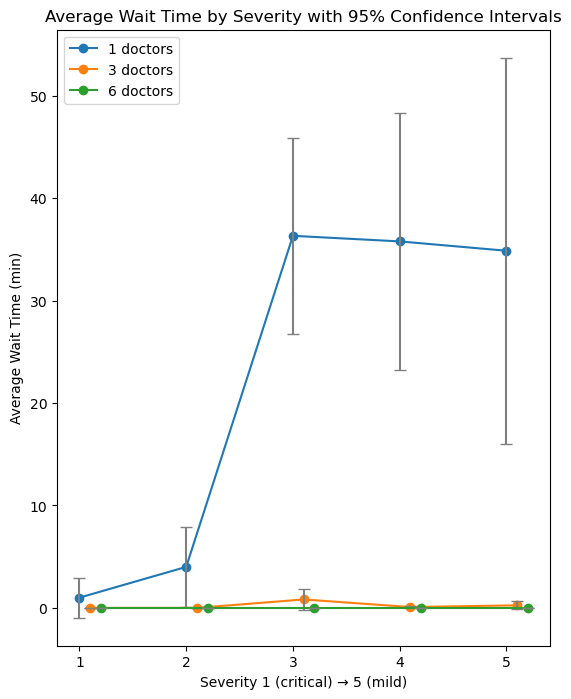

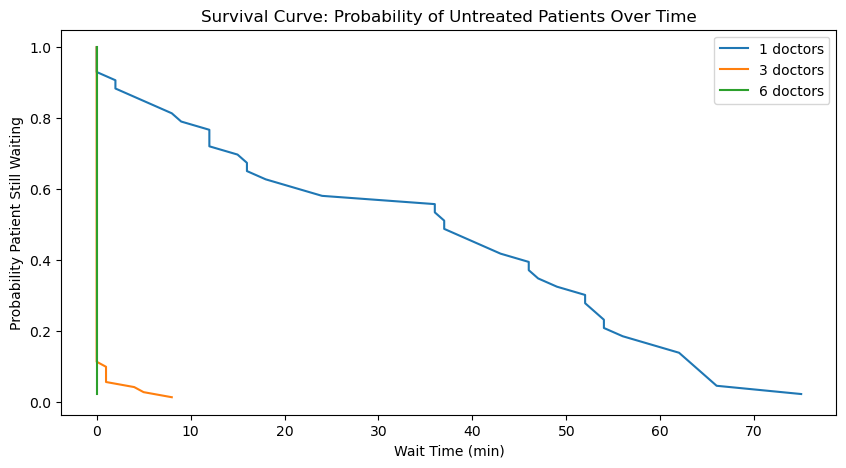


Summary:

Doctors: 1
  Arrived: 51
  Treated: 43
  Avg waits (sev1-5): [1, 4, 36.32, 35.77, 34.86]
  % delayed beyond thresholds: [0.0, 0.0, 10.5, 0.0, 0.0]
  Doctor utilizations (%): [92.7]

Doctors: 3
  Arrived: 70
  Treated: 70
  Avg waits (sev1-5): [0, 0, 0.82, 0.08, 0.25]
  % delayed beyond thresholds: [0.0, 0.0, 0.0, 0.0, 0.0]
  Doctor utilizations (%): [67.5, 46.5, 23.5]

Doctors: 6
  Arrived: 43
  Treated: 43
  Avg waits (sev1-5): [0, 0, 0, 0, 0]
  % delayed beyond thresholds: [0.0, 0.0, 0.0, 0.0, 0.0]
  Doctor utilizations (%): [51.7, 24.4, 4.6, 4.8, 0.0, 0.0]


In [60]:
# run example
if __name__ == '__main__':
    # Run comparison with 1, 3, and 6 doctors for an 8-hour day
    doctor_scenarios = [1, 3, 6]
    
    results = compare_doc_scenarios(doctor_counts=doctor_scenarios,
                                    sim_time_minutes=8*60,
                                    arrival_rate_per_min=0.12)

    # Print summary table
    print('\nSummary:')
    for d, metrics, ts in results:
        print(f"\nDoctors: {d}")
        print(f"  Arrived: {metrics['total_arrived']}")
        print(f"  Treated: {metrics['total_treated']}")
        print(f"  Avg waits (sev1-5): {[round(metrics['avg_waits'][s],2) for s in [1,2,3,4,5]]}")
        print(f"  % delayed beyond thresholds: {[round(metrics['percent_delayed'][s],1) for s in [1,2,3,4,5]]}")
        print(f"  Doctor utilizations (%): {[round(u*100,1) for u in metrics['doc_utilization_percent']]}")